# Practical Assignment — Centrality measures

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In this assignment, we will use Moscow Metro underground stations dataset taken from [Moscow Subway Optimal* Complete Route](https://medium.com/altsoph/moscow-subway-optimal-complete-route-ac98796dd652) research. Let us download and take a look at the data.

In [2]:
station_url = 'https://raw.githubusercontent.com/vpozdnyakov/network_science_assignments/master/assignment_centrality_measures/stations_data.csv'
routes_url = 'https://raw.githubusercontent.com/vpozdnyakov/network_science_assignments/master/assignment_centrality_measures/routes_data.csv'

In [3]:
stations = pd.read_csv(station_url)
routes = pd.read_csv(routes_url)

In [4]:
stations.head()

,id,line_name,station_name,station_type,delay_morning,delay_rush,delay_night,lat,lon
0,0,Sokolnicheskaya,Bulvar Rokossovskogo,deadend,120,90,360,55.814269,37.735117
1,1,Sokolnicheskaya,Cherkizovskaya,pass,120,90,360,55.802991,37.744825
2,2,Sokolnicheskaya,Preobrazhenskaya ploschad,pass,120,90,360,55.796172,37.715022
3,3,Sokolnicheskaya,Sokolniki,pass,120,90,360,55.789200,37.679706
4,4,Sokolnicheskaya,Krasnoselskaya,pass,120,90,360,55.779853,37.666077


In [5]:
routes.head()

,id_from,id_to,route_type,delay
0,0,1,drive,120
1,1,0,drive,120
2,1,2,drive,240
3,2,1,drive,240
4,2,3,drive,180


### Task 1. Metro graph (2 points)

Before we start analyzing centrality, let us build a graph of stations.

Write a function `metro_graph` that takes datasets `stations` and `routes` and returns a graph with all stations and routes of any type. Labels of nodes are in column `stations.id`. Nodes in `G.nodes` viewer should be in ascending order. All nodes should have attributes `station_name` and `line_name`.

In [6]:
def metro_graph(stations, routes):
    '''Build a graph with metro stations and routes'''
    G = nx.Graph()
    G.add_nodes_from(stations.id)
    G.add_edges_from(routes[["id_from", "id_to"]].values)
    nx.set_node_attributes(G, stations.station_name, "station_name")
    nx.set_node_attributes(G, stations.line_name, "line_name")
    return G

In [7]:
'''Check ordering of nodes, number of nodes, names of stations and lines'''
G = metro_graph(stations, routes)
assert (np.array(list(G.nodes)) == np.arange(194)).sum() == 194
assert G.number_of_edges() == 228
assert G.nodes[100]['station_name'] == 'Shabolovskaya'
assert G.nodes[100]['line_name'] == 'Kaluzhsko-Rizhskaya'

Let us draw the graph with default spring layout.

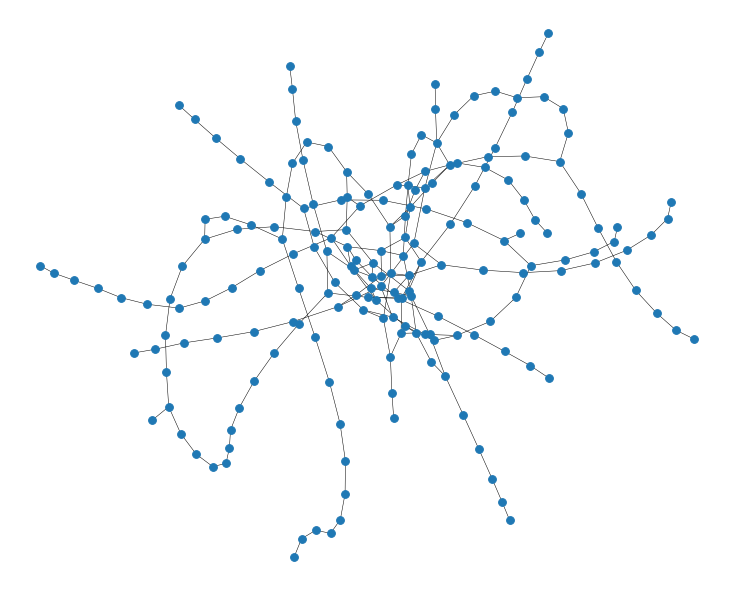

In [8]:
plt.figure(figsize=(10, 8))
nx.draw(G, 
        width=0.5,
        node_size=60)
plt.show()

So far it does not look like a metro map. Let us specify a distance based layout using information from the dataset `stations`.

Write a function `metro_layout` that takes the dataset `stations` and returns a dictionary with nodes as keys and positions as values:
```
{node_id: [longitude, latitude]}
```

In [9]:
def metro_layout(stations):
    '''Build a distance based layout of the metro graph'''
    return stations.apply(lambda s: [s['lon'], s['lat']], axis=1).to_dict()

In [10]:
'''Check a type and positions of some random nodes'''
pos = metro_layout(stations)
assert type(pos) == dict
assert len(pos) == 194
assert pos[100] == [37.6078018, 55.71882329]
assert pos[172] == [37.72840065, 55.69297728]

Let us draw the graph with the distance based layout.

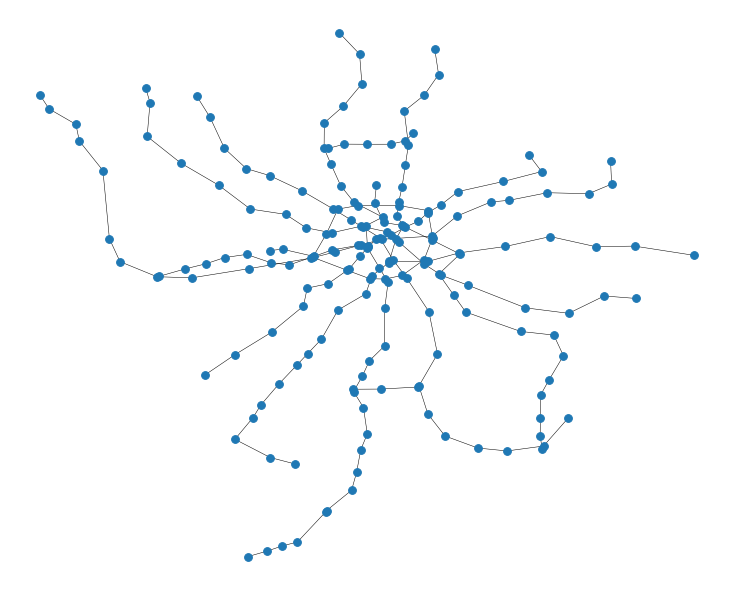

In [11]:
plt.figure(figsize=(10, 8))
nx.draw(G, 
        pos,
        width=0.5,
        node_size=60)
plt.show()

The final preprocessing step, let us colorize stations by their lines.

Write a function `station_color` that takes a graph `G` and returns a dictionary with nodes as keys and color as values. Colors are given in the `line_color` dictionary.

In [12]:
line_color = {
    'Sokolnicheskaya': 'tab:red',
    'Zamoskvoretskaya': 'tab:green',
    'Arbatsko-Pokrovskaya': 'tab:blue',
    'Filevskaya': 'deepskyblue',
    'Koltsevaya': 'tab:brown',
    'Kaluzhsko-Rizhskaya': 'tab:orange',
    'Tagansko-Krasnopresnenskaya': 'tab:purple', 
    'Kalininskaya': 'gold',
    'Serpuhovsko-Timiryazevskaya': 'gray', 
    'Lyublinsko-Dmitrovskaya': 'yellowgreen',
    'Kahovskaya': 'paleturquoise', 
    'Butovskaya': 'lightblue', 
    'Monorels': 'royalblue'
}

In [13]:
def station_color(G):
    '''Returns colors of stations'''
    return {n: line_color[G.nodes[n]["line_name"]] for n in G.nodes}

In [14]:
'''Check a type and colors of some random nodes'''
nx.set_node_attributes(G, station_color(G), 'color')
assert type(station_color(G)) == dict
assert len(station_color(G)) == 194
assert station_color(G)[9] == 'tab:red'
assert station_color(G)[193] == 'royalblue'
assert station_color(G)[119] == 'tab:purple'

Let us draw the graph with the distance based layout and stations colors.

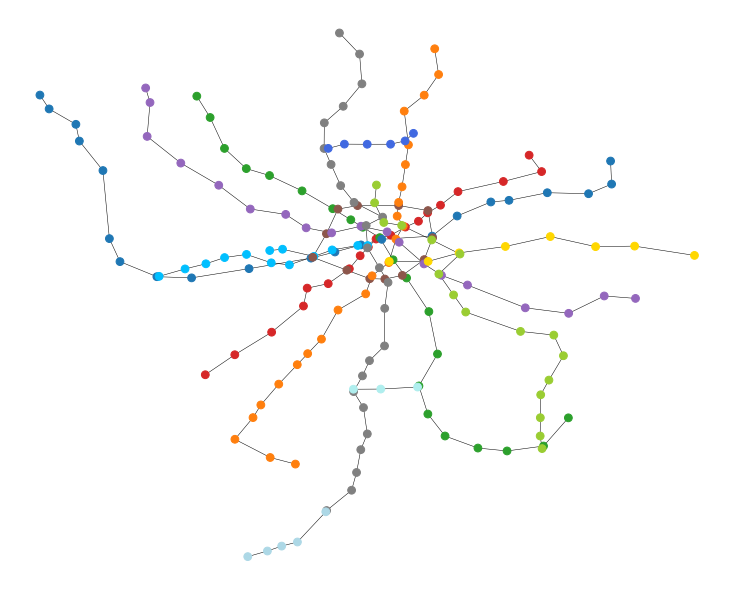

In [15]:
plt.figure(figsize=(10, 8))
nx.draw(
    G, 
    pos,
    width=0.5,
    node_color=list(nx.get_node_attributes(G, 'color').values()),
    node_size=60,
)
plt.show()

### Task 2. Degree, closeness, betweenness centralities (2 points)

Let us look at centrality measures of the metro stations graph. First, use networkx to calculate degree, closeness, betweenness centralities.

Write a function `centralities` that takes a graph `G` and returns a dictionary with keys `degree`, `closeness`, `betweenness`. The values are np.arrays with values of each centrality.

In [16]:
def centralities(G):
    '''Calculate degree, closeness, betweenness centralities of the graph'''
    return {
        "degree": np.array(list(nx.centrality.degree_centrality(G).values())),
        "closeness": np.array(list(nx.centrality.closeness_centrality(G).values())),
        "betweenness": np.array(list(nx.centrality.betweenness_centrality(G).values())),
    }

In [17]:
'''Check some random values of centralities'''
c = centralities(G)
assert c['degree'].shape[0] == 194
assert c['degree'][193] == 0.0051813471502590676
assert c['closeness'][94] == 0.12107904642409034
assert c['betweenness'][49] == 0.0991400402993669

Next, let us create a table with top 10 nodes for each centrality.

Write a function `top10_centralities` that takes a graph `G` and returns a dictionary with keys `degree`, `closeness`, `betweenness`. The values are pd.DataFrames with columns:
* `station` — station name
* `line` — line name
* `centrality` — value of a centrality

Each dataframe contains 10 rows with highest centrality values.

In [18]:
def top10_centralities(G):
    '''Create table of top 10 nodes by degree, closeness, betweenness centralities'''
    cases = [["degree", nx.degree_centrality(G)],
             ["closeness", nx.closeness_centrality(G)],
             ["betweenness", nx.betweenness_centrality(G)]]
    dfs = {}
    for title, centrality in cases:
        dfs[title] = pd.DataFrame({"station": stations["station_name"],
                                   "line": stations["line_name"],
                                   "centrality": centrality
                                  }).sort_values(by="centrality", ascending=False).head(10)
    return dfs

In [19]:
'''Check that some random nodes are in the top 10 tables'''
top_dfs = top10_centralities(G)
assert 'Biblioteka imeni Lenina' in top_dfs['degree']['station'].to_list()
assert 'Serpuhovskaya' in top_dfs['betweenness']['station'].to_list()
assert 'Teatralnaya' in top_dfs['closeness']['station'].to_list()
assert 'Arbatsko-Pokrovskaya' in top_dfs['closeness']['line'].to_list()

Following code makes a visualization: for each centrality it prints a top 10 table and graph, where the node size and color correspond to the centrality value.

Degree centrality


,station,line,centrality
69,Kievskaya,Filevskaya,0.025907
49,Arbatskaya,Arbatsko-Pokrovskaya,0.025907
10,Biblioteka imeni Lenina,Sokolnicheskaya,0.025907
149,Borovitskaya,Serpuhovsko-Timiryazevskaya,0.020725
123,Taganskaya,Tagansko-Krasnopresnenskaya,0.020725
28,Teatralnaya,Zamoskvoretskaya,0.020725
27,Tverskaya,Zamoskvoretskaya,0.020725
79,Taganskaya,Koltsevaya,0.020725
80,Kurskaya,Koltsevaya,0.020725
148,Chehovskaya,Serpuhovsko-Timiryazevskaya,0.020725


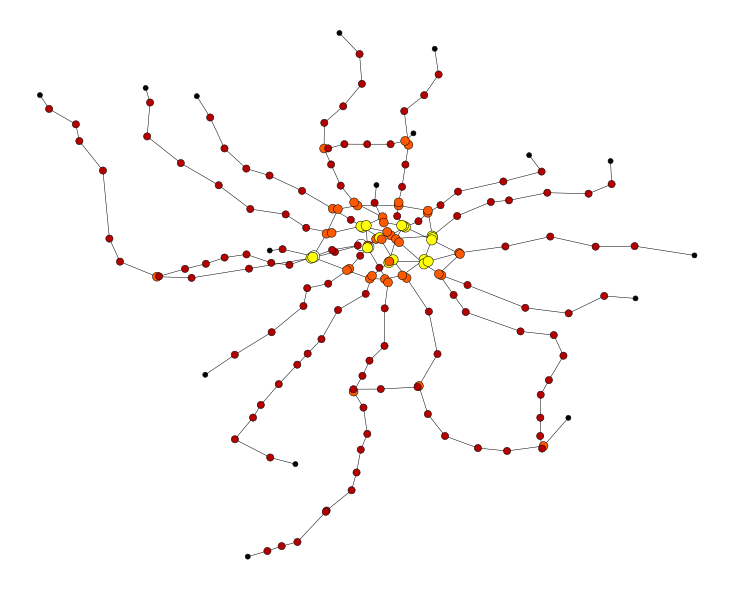

Closeness centrality


,station,line,centrality
28,Teatralnaya,Zamoskvoretskaya,0.141288
48,Ploschad Revolyutsii,Arbatsko-Pokrovskaya,0.141185
29,Novokuznetskaya,Zamoskvoretskaya,0.139350
80,Kurskaya,Koltsevaya,0.138849
79,Taganskaya,Koltsevaya,0.138849
49,Arbatskaya,Arbatsko-Pokrovskaya,0.138451
148,Chehovskaya,Serpuhovsko-Timiryazevskaya,0.137956
78,Paveletskaya,Koltsevaya,0.137857
77,Dobryninskaya,Koltsevaya,0.137464
98,Tretyakovskaya,Kaluzhsko-Rizhskaya,0.137269


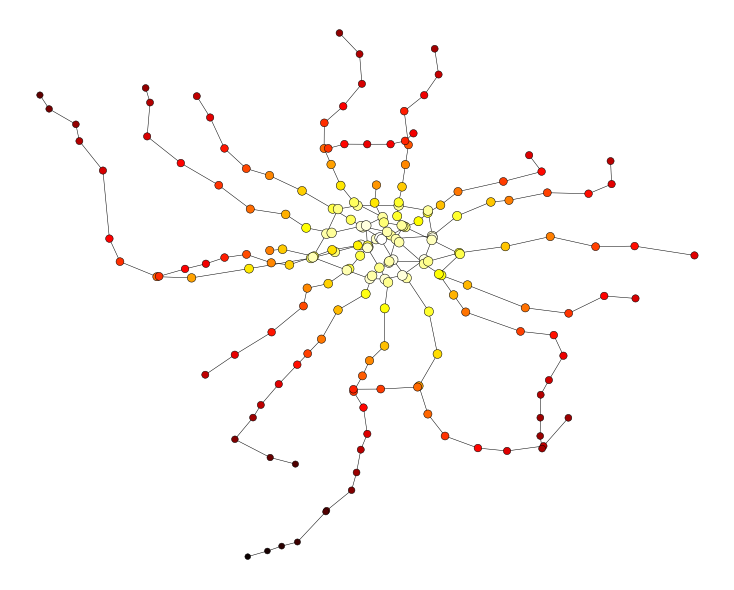

Betweenness centrality


,station,line,centrality
86,Kievskaya,Koltsevaya,0.172276
151,Serpuhovskaya,Serpuhovsko-Timiryazevskaya,0.144095
51,Kievskaya,Arbatsko-Pokrovskaya,0.133394
152,Tulskaya,Serpuhovsko-Timiryazevskaya,0.130192
75,Park kultury,Koltsevaya,0.130139
77,Dobryninskaya,Koltsevaya,0.129763
76,Oktyabrskaya,Koltsevaya,0.124274
99,Oktyabrskaya,Kaluzhsko-Rizhskaya,0.122584
153,Nagatinskaya,Serpuhovsko-Timiryazevskaya,0.122204
85,Krasnopresnenskaya,Koltsevaya,0.122121


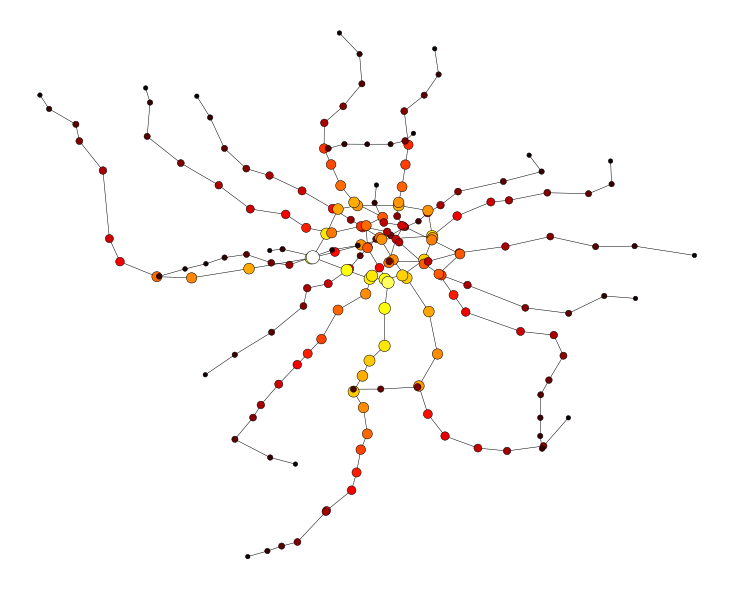

In [20]:
cases = [['degree', 5000, 0, 'Degree centrality'], 
         ['closeness', 700, 0, 'Closeness centrality'], 
         ['betweenness', 900, 20, 'Betweenness centrality']]
for c_key, scale, bias, title in cases:
    print(title)
    display(top_dfs[c_key])
    plt.figure(figsize=(10, 8))
    nx.draw(G, 
            pos,
            width=0.5,
            linewidths=0.5,
            edgecolors='black',
            cmap=plt.cm.hot,
            node_size=c[c_key]*scale + bias,
            node_color=c[c_key])
    plt.show()

### Task 3. Center of the graph (2 points)

In the next section we will slightly modify the initial graph — truncate all stations that located outside of Koltsevaya line.

Write a function `metro_graph_center` that takes a metro graph `G` and returns a subgraph with stations on Koltsevaya line and stations inside Koltsevaya line.

In [21]:
def metro_graph_center(G):
    '''Build a subgraph with stations inside Koltsevaya line'''
    nodes = [x[0] for x in list(nx.closeness_centrality(G).items()) if x[1] > 0.12]
    nodes.append(6)
    nodes.append(70)
    nodes.append(71)
    del nodes[nodes.index(135)]
    del nodes[nodes.index(31)]
    del nodes[nodes.index(168)]
    del nodes[nodes.index(46)]
    subG = G.subgraph(nodes).copy()
    return subG

In [22]:
'''Check the number of nodes and edges and some random stations'''
subG = metro_graph_center(G)
assert len(subG.nodes) == 57
assert len(subG.edges) == 85
assert 149 in list(subG.nodes)
assert 82 in list(subG.nodes)
assert 137 in list(subG.nodes)

Let us draw the center of the metro graph with station names and colors.

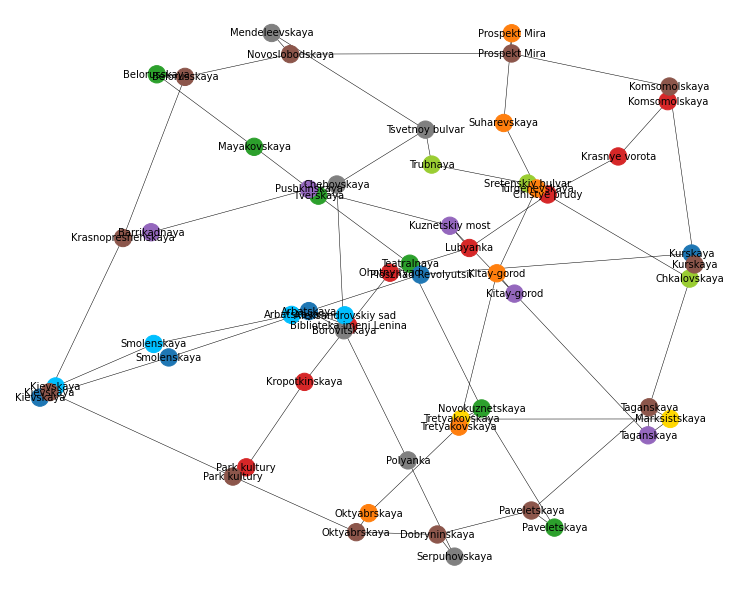

In [23]:
plt.figure(figsize=(10, 8))
nx.draw(subG, 
        pos,
        width=0.5,
        node_color=list(nx.get_node_attributes(subG, 'color').values()),
        labels=nx.get_node_attributes(subG, 'station_name'),
        font_size=10)
plt.show()

### Task 4. Centralization (1 point)

The center of the metro graph looks a bit like a circular graph. We can see that a circular graph has the lowest centralization since

$$\text{Centralization} = \frac{\sum_i^N[C_x(p_*) - C_x(p_i)]}{\max\sum_i^N[C_x(p_*) - C_x(p_i)]}$$

where 
* $C_x$ — some centrality measure
* $p_i$ — $i$-th node
* $p_*$ — node with the largest centrality value
* $\max$ — maximum over all possible graphs with the same number of nodes (a star graph for degree, betweenness, closeness centralities).

Let us check how centralization changes during transformation our truncated graph into a pure circular graph.

Write a function `centralization_seq` that takes the truncated graph `G` and deletes stations inside Koltsevaya line one-by-one in ascending order. In each step the centralization is calculated. The function returns a dictionary with keys `degree`, `closeness`, `betweenness` and values — np.arrays with centralization values.

In [24]:
def centralization_seq(G):
    '''Delete stations and calculate centralization for degree, closeness, betweenness'''
    to_del = [n for n, name in nx.get_node_attributes(G, "line_name").items() if name != "Koltsevaya"]
    res = dict()
    n_nodes = G.number_of_nodes()
    cases = [
        (nx.degree_centrality, "degree"),
        (nx.closeness_centrality, "closeness"),
        (nx.betweenness_centrality, "betweenness")
    ]
    for func, name in cases:
        vals = []
        star = nx.star_graph(n_nodes)
        den = np.array(list(func(star).values()))
        iterG = G.copy()
        for n in sorted(to_del):
            nodes = np.array(list(iterG.nodes))
            iterG = iterG.subgraph(nodes[nodes != n]).copy()
            num = np.array(list(func(iterG).values()))
            vals.append((num.max() - num).sum() / (den.max() - den).sum())
        res[name] = np.array(vals)
    return res

In [25]:
'''Check the output shape and some random centralization values'''
cent = centralization_seq(subG)
assert cent['degree'].shape == (45,)
assert cent['closeness'].shape == (45,)
assert cent['betweenness'].shape == (45,)
assert cent['degree'][-1] == cent['betweenness'][-1] == cent['closeness'][-1]
assert cent['degree'][41].round(4) == 0.0191
assert cent['degree'][2].round(4) == 0.0377
assert cent['closeness'][11].round(4) == 0.0604
assert cent['closeness'][9].round(4) == 0.0656
assert cent['betweenness'][14].round(4) == 0.0847

Let us draw how the centralization changes when the graph tends to a circular graph.

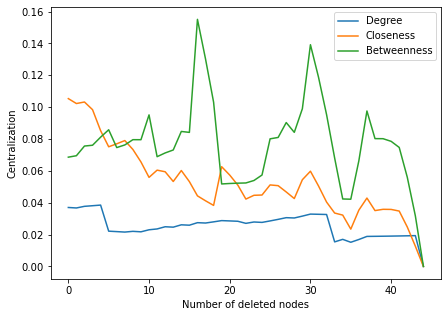

In [26]:
plt.figure(figsize=(7, 5))
plt.plot(cent['degree'], label='Degree')
plt.plot(cent['closeness'], label='Closeness')
plt.plot(cent['betweenness'], label='Betweenness')
plt.ylabel('Centralization')
plt.xlabel('Number of deleted nodes')
plt.legend()
plt.show()

### Task 5. Katz centrality (2 points)

Katz centrality is based on the number of all paths (not only shortest) passing through a node. By the way, how to quickly calculate the total number of fixed length paths between two nodes?

Write a function `number_of_paths` that takes graph `G`, nodes `i`, `j` and the length of paths `n`. The function returns the number of paths.

In [27]:
def number_of_paths(G, i, j, n):
    '''Calculate number of paths of length n'''
    nodes = np.array(list(G.nodes))
    i_index = np.where(nodes == i)[0][0]
    j_index = np.where(nodes == j)[0][0]
    adj_matrix = nx.convert_matrix.to_numpy_matrix(G)  # здесь оставил матрицу чтобы можно было возводить в степень
    return (adj_matrix ** n)[i_index, j_index]

In [28]:
'''Check some paths in the city center'''
# Paveletskaya (Koltsevaya) - Ohotny ryad. Length 4
# Single path: Paveletskaya (Koltsevaya) -> Paveletskaya (Zamoskvoretskaya) 
# -> Novokuznetskaya -> Teatralnaya -> Ohotny ryad
assert number_of_paths(subG, 78, 9, 4) == 1
# Novoslobodskaya - Pushkinskaya. Length 4
# 1st path: Novoslobodskaya -> Belorusskaya -> Krasnopresnenskaya
# -> Barrikadnaya -> Pushkinskaya
# 2nd path: Novoslobodskaya -> Mendeleevskaya -> Tsvetnoy bulvar
# -> Chehovskaya -> Pushkinskaya
assert number_of_paths(subG, 83, 120, 4) == 2
# Novoslobodskaya - Pushkinskaya. Length 7. Many paths.
assert number_of_paths(subG, 83, 120, 7) == 31

Now we can apply similar approach in calculation Katz centrality. The formula is

$$k_i = \beta\sum_j A_{ij} + \beta^2\sum_j A_{ij}^2 + \beta^3\sum_j A_{ij}^3 + \dots$$

where $\beta$ is an attenuation factor with restriction 

$$\beta < \frac{1}{\lambda}$$

where $\lambda$ is a largest eigenvalue of a matrix $A$.

Write a function `katz_centrality` that takes a graph `G`, number of iterations `n`, attenuation factor `beta` and returns a np.array of centrality values.

In [29]:
def katz_centrality(G, n, beta):
    '''Calculate Katz centrality'''
    nodes = np.array(list(G.nodes))
    n_nodes = nodes.shape[0]
    k = np.zeros(n_nodes)
    adj_matrix = nx.to_numpy_array(G)
    max_eigen_value = np.sort(np.linalg.eigvals(adj_matrix))[-1]
    if beta >= (1 / max_eigen_value):
        raise Exception("Incorrect beta")
    A = None
    b = None
    for i in range(1, n + 1):
        if A is None or b is None:
            A = adj_matrix
            b = beta
        else:
            A = A @ adj_matrix
            b = b * beta
        k = k + b * A.sum(axis=1)
    return k

In [30]:
'''Check the restriction on beta and networkx implementation'''
beta = 1 / 3
try:
    katz = katz_centrality(G, 1, beta)
except:
    pass
else:
    raise AssertionError("Did not raise an exception")
beta = 1 / 5
assert 0.9999 < np.corrcoef(katz_centrality(G, 1, beta), c['degree'])[0][1] <= 1
nxkatz = np.array([val for val in nx.katz_centrality(G, beta).values()])
assert 0.9999 < np.corrcoef(katz_centrality(G, 20, beta), nxkatz)[0][1] <= 1

Let us draw the graph with Katz centrality visualization.

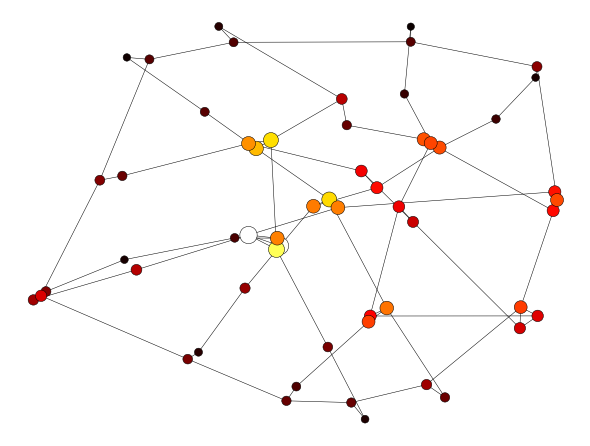

In [31]:
katz_c = katz_centrality(subG, 20, 1/4)
katz_c = katz_c / katz_c.max()
plt.figure(figsize=(8, 6))
nx.draw(subG, 
        pos,
        width=0.5,
        linewidths=0.5,
        edgecolors='black',
        cmap=plt.cm.hot,
        node_size=katz_c*300,
        node_color=katz_c)
plt.show()

Here we can see how Katz centrality converges by the number of iterations.

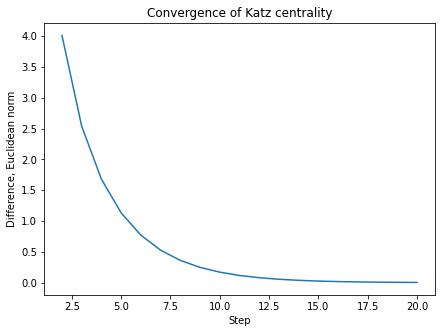

In [32]:
plt.figure(figsize=(7, 5))
convergence = []
old_katz = katz_centrality(G, 1, 0.2)
step_space = np.arange(2, 21)
for i in step_space:
    katz = katz_centrality(G, i, 0.2)
    convergence.append(np.linalg.norm(katz - old_katz))
    old_katz = katz.copy()
plt.plot(step_space, convergence)
plt.ylabel('Difference, Euclidean norm')
plt.xlabel('Step')
plt.title('Convergence of Katz centrality')
plt.show()

### Task 6. Eigenvector centrality (0.5 point)

Let us implement eigenvector centrality that can be interpreted as influence of a node. A centrality value of a node takes into account centrality values of its neighbors, that is

$$v_i = \frac{1}{\lambda}\sum_j A_{ij} v_j$$

or in the matrix form

$$Av = \lambda v$$

where $\lambda$ is the largest eigenvalue.

Write a function `eigenvector_centrality` that takes an adjacency matrix `A` and returns a np.array with centrality values.

In [41]:
def eigenvector_centrality(A):
    '''Calculate eigenvector centrality'''
    w, v = np.linalg.eig(A)
    max_i = np.argsort(w)[-1]
    return v[:, max_i] #* -1

In [42]:
'''Check some random values'''
eig_c = eigenvector_centrality(nx.to_numpy_array(subG))
assert eig_c.shape == (57, )
assert eig_c[0].round(4) == 0.0244
assert eig_c[-1].round(4) == 0.0701
assert eig_c[25].round(4) == 0.1198

AssertionError: 

Let us draw the graph with eigenvector centrality visualization.

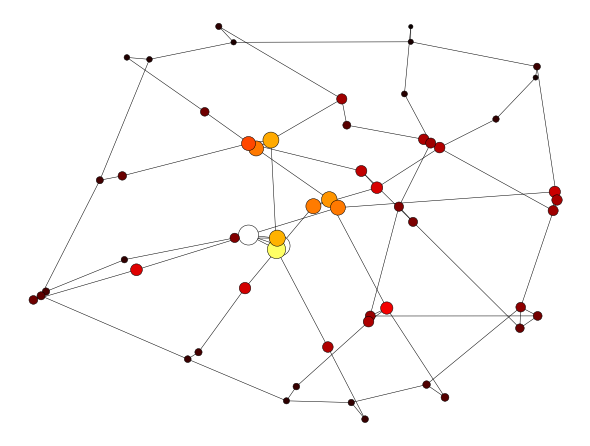

In [35]:
plt.figure(figsize=(8, 6))
nx.draw(subG, 
        pos,
        width=0.5,
        linewidths=0.5,
        edgecolors='black',
        cmap=plt.cm.hot,
        node_size=eig_c/eig_c.max()*400,
        node_color=eig_c)
plt.show()

### Task 7. Correlations (0.5 point)

Finally, let us see the relation between centralities. Calculate Pearson correlation coefficient and then we will draw scatter plots on pairs of centralities.

Write a function `pearson_correlation` that takes two np.arrays and returns Person correlation coefficient.

In [36]:
def pearson_correlation(i_vals, j_vals):
    '''Calculate Pearson correlation coefficient'''
    return abs(np.corrcoef(i_vals, j_vals)[0, 1])

In [37]:
'''Check some coefficients'''
centvals = [
    ('Degree', list(nx.degree_centrality(G).values())),
    ('Closeness', list(nx.closeness_centrality(G).values())),
    ('Betweenness', list(nx.betweenness_centrality(G).values())),
    ('Katz', katz_centrality(G, 20, 1/5)), 
    ('Eigenvector', eigenvector_centrality(nx.to_numpy_array(G)))
]
assert pearson_correlation(centvals[0][1], centvals[0][1]) == 1
assert round(pearson_correlation(centvals[4][1], centvals[2][1]), 4) == 0.3358
assert round(pearson_correlation(centvals[4][1], centvals[3][1]), 4) == 0.9169
assert round(pearson_correlation(centvals[0][1], centvals[1][1]), 4) == 0.7211
assert round(pearson_correlation(centvals[3][1], centvals[4][1]), 4) == 0.9169

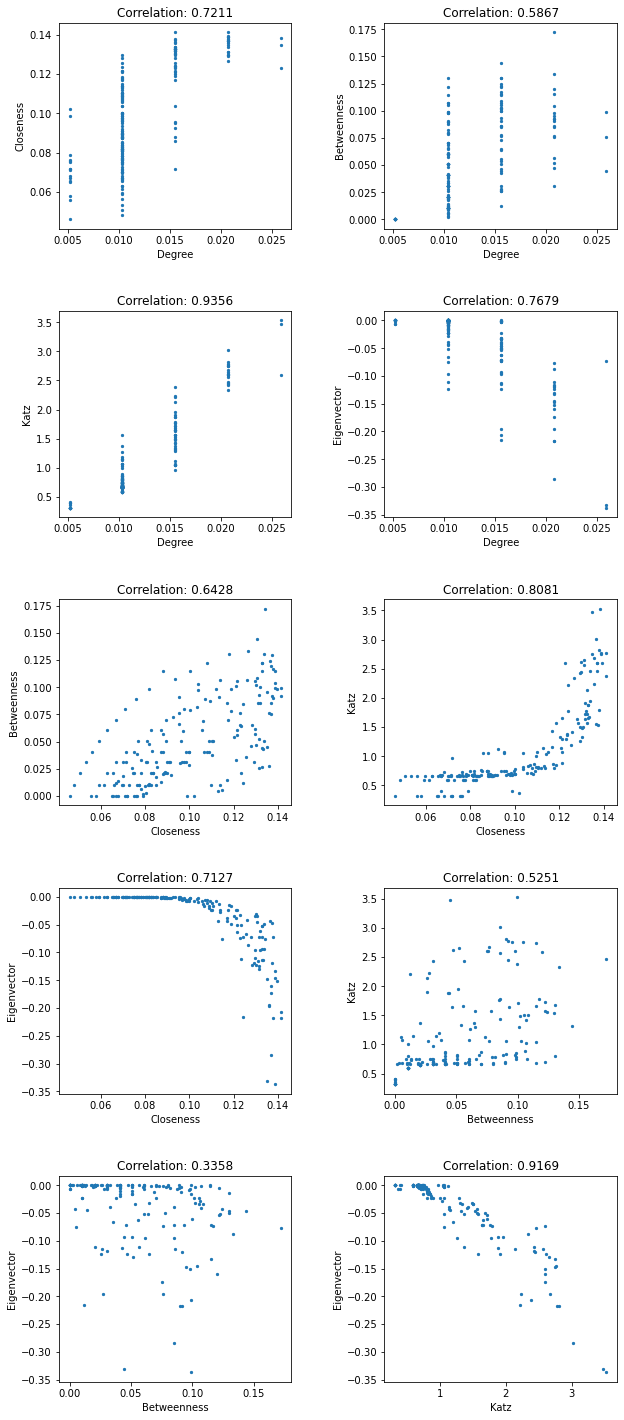

In [38]:
plt.figure(figsize=(2*5, 5*5))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
k = 1
for i in range(len(centvals)):
    for j in range(i + 1, len(centvals)):
        i_label, i_vals = centvals[i]
        j_label, j_vals = centvals[j]
        correlation = pearson_correlation(i_vals, j_vals)
        plt.subplot(5, 2, k)
        plt.scatter(i_vals, j_vals, s=5)
        plt.title('Correlation: {:.4f}'.format(correlation))
        plt.xlabel(i_label)
        plt.ylabel(j_label)
        k += 1